# (c) Analyze the influence of the number of convolution layers on the predictive performance. 

Do your results indicate that oversmoothing is an issue? Consider quantifying the degree of oversmoothing using a metric such as the rank-one distance [3], the error of low-rank approximations, or the Dirichlet energy [3]:

$$
E(X^{(n)}) = \frac{1}{2} \sum_{(i,j) \in E} \left\| \frac{X_i^{(n)}}{\sqrt{1 + \text{deg}(i)}} - \frac{X_j^{(n)}}{\sqrt{1 + \text{deg}(j)}} \right\|_2^2,
$$

where $X^{(n)}$ is the node feature matrix at layer $n$.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import RandomNodeSplit
from tqdm.auto import tqdm


/Users/marlene/Documents/data/Projects/17_try_neural_networks/Code/Graph_learning_task/graph_learning/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



# Influence of number of conv layers on performance
As visible from the plots in 2_a.ipynb, the number of convolution layers has a significant influence on the predictive performance. The best validation accuracy is achieved with 2 layers. Increasing the number of layers beyond that leads to a decrease in validation accuracy, indicating that oversmoothing is indeed an issue in this case.

In [2]:


torch.manual_seed(42)

# load data
dataset = Planetoid(root=os.path.join('data', 'Planetoid'), name='Cora')
standard_split = RandomNodeSplit()
node_split_data = standard_split(dataset[0])

# declare classes as in 2_a 

class GNN(torch.nn.Module):
    def __init__(self, input_dim=1433,output_dim=7, hidden_channels=16, num_layers=2, dropout=0.5,inner_layers=GCNConv,output_layer=Linear):
        super(GNN, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(inner_layers(input_dim, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(inner_layers(hidden_channels, hidden_channels))
        self.convs.append(inner_layers(hidden_channels, hidden_channels))
        self.dropout = dropout
        self.output_layer = output_layer(hidden_channels, output_dim)

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = torch.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        x = self.output_layer(x)

        return F.log_softmax(x, dim=1)

    def forward_unit_layer(self, x, edge_index, layer):
        with torch.no_grad():
            if layer == 0:
                return x
            else:
                for conv in self.convs[:layer-1]:
                    x = conv(x, edge_index)
                    x = torch.relu(x)
                x = self.convs[layer-1](x, edge_index)
            return x


class Trainer:
    def __init__(self, model, data, lr=0.01, weight_decay=5e-4, show_progress=True):
        self.model = model
        self.data = data
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        self.criterion = torch.nn.NLLLoss()
        self.show_progress = show_progress

    def train_step(self):
        self.model.train()
        self.optimizer.zero_grad()
        out = self.model(self.data.x, self.data.edge_index)
        loss = self.criterion(out[self.data.train_mask], self.data.y[self.data.train_mask])
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def evaluate(self, mask):
        self.model.eval()
        out = self.model(self.data.x, self.data.edge_index)
        pred = out.argmax(dim=1)
        correct = (pred[mask] == self.data.y[mask]).sum().item()
        acc = correct / mask.sum().item()
        return acc
    
    def train(self, epochs=200):
        ProgressBar = tqdm(range(epochs)) if self.show_progress else range(epochs)
        for epoch in ProgressBar:
            loss = self.train_step()
            train_acc = self.evaluate(self.data.train_mask)
            val_acc = self.evaluate(self.data.val_mask)
            test_acc = self.evaluate(self.data.test_mask)
            if self.show_progress:
                ProgressBar.set_description(f"Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")


### Implement Dirichlet energy [3]:

$$
E(X^{(n)}) = \frac{1}{2} \sum_{(i,j) \in E} \left\| \frac{X_i^{(n)}}{\sqrt{1 + \text{deg}(i)}} - \frac{X_j^{(n)}}{\sqrt{1 + \text{deg}(j)}} \right\|_2^2,
$$

where $X^{(n)}$ is the node feature matrix at layer $n$.

In [3]:
def dirichlet_energy(edge_index,X):
    degrees = torch.bincount(edge_index[0])
    norm = degrees + torch.ones_like(degrees)
    norm = norm.float().pow(-0.5)
    D_norm = torch.diag(norm)
    X_norm = D_norm @ X

    energy = 0.0
    for i,j in edge_index.t():
        energy += (X_norm[i]-X_norm[j]) @ (X_norm[i]-X_norm[j]).t()

    return energy/2

dirichlet_energy(dataset[0].edge_index,dataset[0].x)


tensor(30079.6777)

### Analyze Dirichlet energy of every layer for different number of layers

We use the best hyperparameters found in 2_a.ipynb for this analysis and just vary the number of layers.

#### We first train models with different number of layers using the best hyperparameters found before, store them and visiualize their performance. 

[16 2 0.5 0.001 200 <class 'torch_geometric.nn.conv.gcn_conv.GCNConv'>]


Loss: 0.3154, Train Acc: 0.9487, Val Acc: 0.8760, Test Acc: 0.8750: 100%|██████████| 200/200 [00:01<00:00, 111.94it/s]
Loss: 0.5499, Train Acc: 0.8940, Val Acc: 0.8460, Test Acc: 0.8460: 100%|██████████| 200/200 [00:02<00:00, 71.23it/s]
Loss: 1.2557, Train Acc: 0.5447, Val Acc: 0.5040, Test Acc: 0.5280: 100%|██████████| 200/200 [00:04<00:00, 44.56it/s]
Loss: 1.4277, Train Acc: 0.4412, Val Acc: 0.4400, Test Acc: 0.4630: 100%|██████████| 200/200 [00:07<00:00, 25.41it/s]
Loss: 1.8306, Train Acc: 0.2980, Val Acc: 0.2960, Test Acc: 0.3100: 100%|██████████| 200/200 [00:16<00:00, 12.30it/s]
Loss: 1.8318, Train Acc: 0.2980, Val Acc: 0.2960, Test Acc: 0.3100: 100%|██████████| 200/200 [00:33<00:00,  6.03it/s]
Loss: 1.8318, Train Acc: 0.2980, Val Acc: 0.2960, Test Acc: 0.3100: 100%|██████████| 200/200 [01:09<00:00,  2.89it/s]


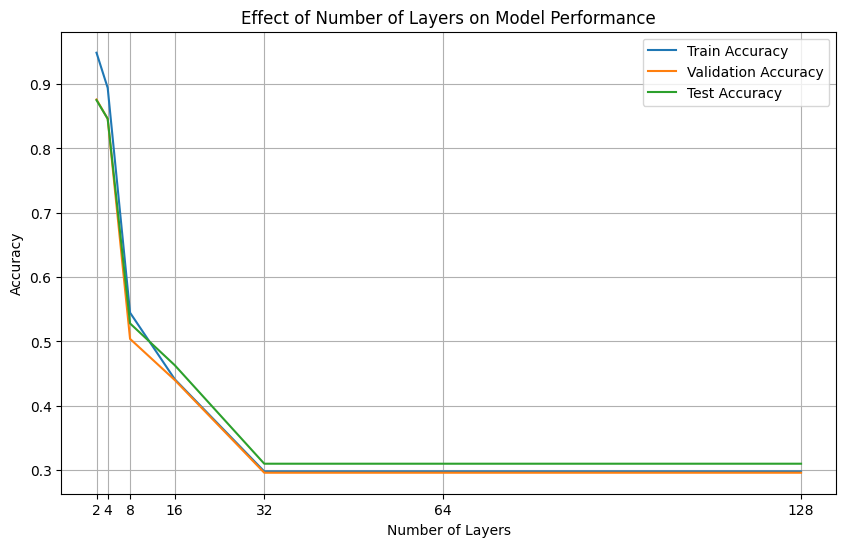

In [4]:
# load the params and evaluation values from the last exercise
with np.load("gridsearch.npz",allow_pickle=True) as data:
    param_grid = data['param_grid']
    train_accuracies = data['train_accuracies']
    val_accuracies = data['val_accuracies']
    test_accuracies = data['test_accuracies']
    predictions = data['predictions']

# only evaluate the 10 best training runs given validation accuracy
best_i = np.flip(np.argsort(val_accuracies))

print(param_grid[best_i[0]])

hdim, layers, dropout, lr, epochs, conv_layer = param_grid[best_i[0]]
layer_options = [2,4,8,16,32,64,128]
models = []
train_accuracies = []
val_accuracies = []
test_accuracies = []
for layers in layer_options:
    model = GNN(hidden_channels=hdim, num_layers=layers, dropout=dropout, inner_layers=conv_layer)
    trainer = Trainer(model, node_split_data, lr=lr)
    trainer.train(epochs=epochs)
    models.append(model)
    train_accuracies.append(trainer.evaluate(node_split_data.train_mask))
    val_accuracies.append(trainer.evaluate(node_split_data.val_mask))
    test_accuracies.append(trainer.evaluate(node_split_data.test_mask))

# plot the results
plt.figure(figsize=(10,6))
plt.plot(layer_options, train_accuracies, label='Train Accuracy')
plt.plot(layer_options, val_accuracies, label='Validation Accuracy')
plt.plot(layer_options, test_accuracies, label='Test Accuracy')
plt.xlabel('Number of Layers')
plt.ylabel('Accuracy')
plt.title('Effect of Number of Layers on Model Performance')
plt.xticks(layer_options)
plt.legend()
plt.grid()
plt.savefig('accuracy_vs_layers.pdf', bbox_inches='tight')
plt.show()


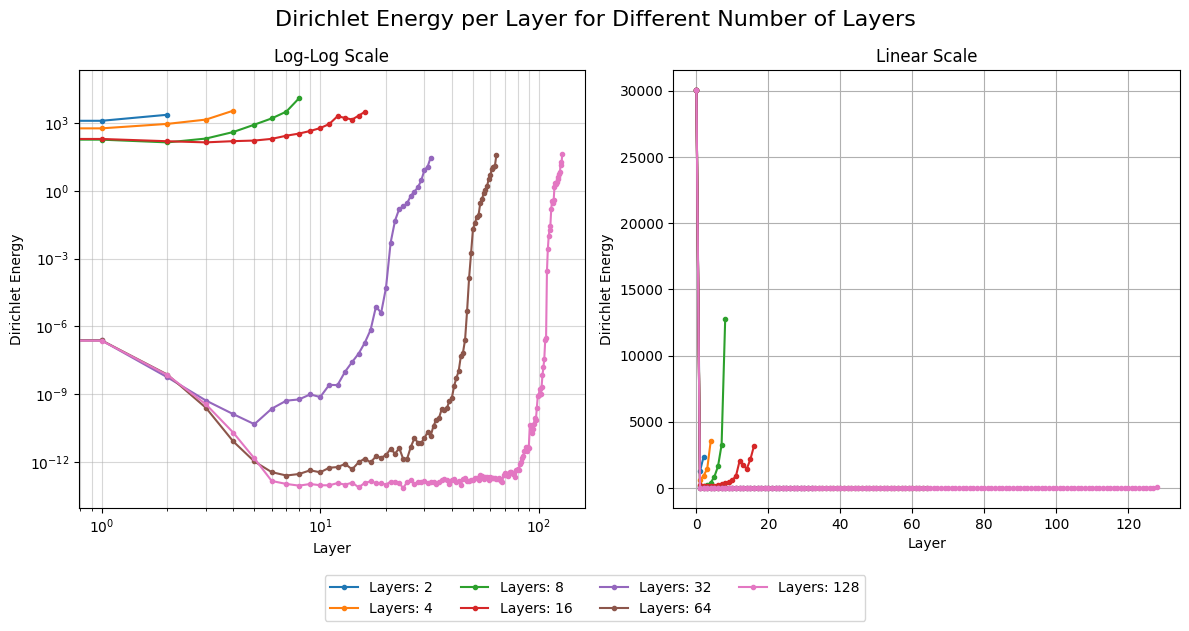

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 

fig.suptitle('Dirichlet Energy per Layer for Different Number of Layers', fontsize=16)

for model in models:
    energies = []
    for layer in range(len(model.convs) + 1):
        out = model.forward_unit_layer(node_split_data.x, node_split_data.edge_index, layer)
        energy = dirichlet_energy(node_split_data.edge_index, out)
        energies.append(energy.item())
    
    ax[0].loglog(range(0, len(model.convs) + 1), energies, marker='.', label=f'Layers: {len(model.convs)}')
    ax[1].plot(range(0, len(model.convs) + 1), energies, marker='.', label=f'Layers: {len(model.convs)}')

ax[0].set_title('Log-Log Scale')
ax[0].set_xlabel('Layer')
ax[0].set_ylabel('Dirichlet Energy')
ax[0].grid(True, which="both", ls="-", alpha=0.5)

ax[1].set_title('Linear Scale')
ax[1].set_xlabel('Layer')
ax[1].set_ylabel('Dirichlet Energy')
ax[1].grid(True)

# Create a single legend below both plots
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4, frameon=True)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15, top=0.88) 
plt.savefig('dirichlet_energy_layers.pdf', bbox_inches='tight')
plt.show()

Oversmoothing is an effect in Graph neural networks where, with an increasing number of layers, node representations become increasingly similar. This removal of local information leads the model to no longer being able to distinguish between nodes, causing a drop in predictive performance. Mathematically, this can be compared to a low-pass filter, where high frequency information (local differences) is continuously removed until embeddings converge to a global average. The results above show this phenomenon. 

**Impact on predictive accuracy**: The first plot above, 
shows the achieved accuracy on the task against the number of layers a model contains. With shallow models we observe peak performance (around 90~\% accuracy). Here, the receptive field is large enough to capture local context, but unique node features are still preserved. With increasing number of layers, we observe a strong drop in accuracy. This happens, because the receptive field of the model exceeds the diameter of the graph. The Cora dataset is a small world network and has a diameter of 19 in its largest connected component. A 32-layer GNN on the other hand, expands the receptive field of a node to 32 hops. This means that every single node is aggregating information from every other node in the graph multiple times. The node embeddings therefore trend towards a global average of the entire dataset. Unique local features, which are required for classification are washed out. With the Cora Dataset having a high homophily, this local information is particularly relevant.

**Analysis of Dirichlet Energy**: The second plot hows the values of the Dirichlet Energy for the output of each layer of a model, against the number of the layer. This allows a layer-wise perspective on the smoothing process. On the left the results can be seen on a log-log scale, on the right on a linear scale. As seen in the linear plot, all models begin with the same high Dirichlet energy at layer 0. This represents the high variance in the input features. The log-log plot then shows a strong decay for the deepest models. There, the energy decreases to close to zero within the first ten layers (especially drastically in the 64 and 128 layer networks). In this zone the hidden representations are effectively all identical, indicating that subsequent layers are computationally useless.

In the final layers, we see that the Dirichlet energy for the deep networks rises again. This happens because Cross-Entropy Loss heavily penalizes predicting uniform probabilities (=low confidence) (due to the ln).  However, since the network is learning from oversmoothed and uninformative node representations at this point, this forces the final layer to magnify tiny, random numerical differences into large score differences. This artificial increase in Dirichlet energy is not related to the actual capture of information, which is also evident by the low prediction accuracy for these types of networks seen in the first plot.

# (d) Analyze how oversmoothing is affected by the labels of the dataset. 
Replace the labels of the Cora dataset
with synthetic labels that encode the local structure of the nodes, e.g., using a suitable vertex invariant.

### Choosing a Vertex Invariant: Node Degree
For this experiment, we chose Node Degree as our invariant. Essentially, we replace the original dataset labels with new labels representing how many connections each node has.

The reasoning is straightforward: while oversmoothing tends to "wash out" the unique feature information that defines the original classes, the underlying graph structure remains constant. By using node degree as labels, we can investigate whether the GCN can still learn meaningful patterns based on structural properties, even when traditional feature-based class distinctions are diminished due to oversmoothing.

In [6]:
out_degrees = torch.bincount(dataset[0].edge_index[0])
in_degrees = torch.bincount(dataset[0].edge_index[1])
y_new = out_degrees + in_degrees

In [7]:
print(y_new.unique().shape)

torch.Size([37])


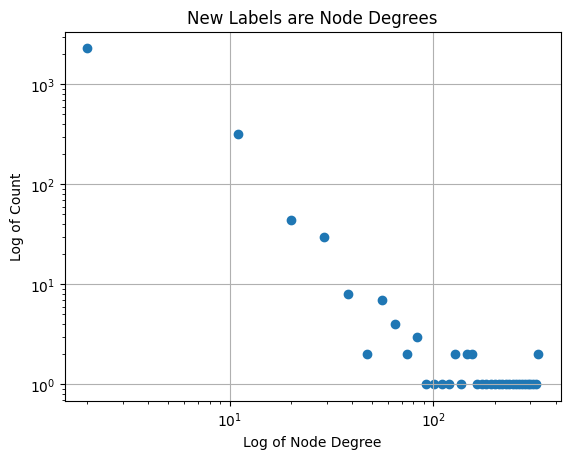

In [8]:
bins = np.histogram_bin_edges(y_new.numpy(), bins=y_new.unique().shape[0])

plt.scatter(bins[:-1], np.histogram(y_new.numpy(), bins=bins)[0]+1)  # +1 to avoid log(0)

plt.xlabel('Log of Node Degree')
plt.ylabel('Log of Count')
plt.title('New Labels are Node Degrees')
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.show()

In [9]:
new_node_split_data = node_split_data.clone()
new_node_split_data.y = y_new.float()

Since this is a regression task now, we adapt the loss function to Mean Squared Error (MSE) to better capture the continuous nature of node degree values.

In [10]:
class RegTrainer(Trainer):
    def __init__(self, model, data, lr=0.01, weight_decay=5e-4, show_progress=True):
        super().__init__(model, data, lr, weight_decay, show_progress)
        self.criterion = torch.nn.MSELoss()

    def evaluate(self, mask):
        self.model.eval()
        out = self.model(self.data.x, self.data.edge_index)
        pred = out.squeeze()
        mse = F.mse_loss(pred[mask], self.data.y[mask])
        return mse.item()
    
    def train(self, epochs=200):
        ProgressBar = tqdm(range(epochs)) if self.show_progress else range(epochs)
        for epoch in ProgressBar:
            loss = self.train_step()
            train_mse = self.evaluate(self.data.train_mask)
            val_mse = self.evaluate(self.data.val_mask)
            test_mse = self.evaluate(self.data.test_mask)
            if self.show_progress:
                ProgressBar.set_description(f"Loss: {loss:.4f}, Train MSE: {train_mse:.4f}, Val MSE: {val_mse:.4f}, Test MSE: {test_mse:.4f}")

We also have to modify the GNN output activation to be linear instead of softmax, as we are predicting continuous values now.

In [11]:
dataset[0].num_nodes

2708

In [12]:
class RegGNN(GNN):
    def __init__(self, input_dim=1433,output_dim=1, hidden_channels=16, num_layers=2, dropout=0.5,inner_layers=GCNConv,output_layer=Linear):
        super().__init__(input_dim,output_dim, hidden_channels, num_layers, dropout,inner_layers,output_layer)

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = torch.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        x = self.output_layer(x)

        return x  # No softmax for regression

In [13]:
# repeat the training with new labels
models = []
train_losses = []
val_losses = []
test_losses = []

for layers in layer_options:
    model = RegGNN(hidden_channels=hdim, num_layers=layers, dropout=dropout, inner_layers=conv_layer)
    trainer = RegTrainer(model, new_node_split_data, lr=lr)
    trainer.train(epochs=epochs)
    models.append(model)
    train_losses.append(trainer.evaluate(new_node_split_data.train_mask))
    val_losses.append(trainer.evaluate(new_node_split_data.val_mask))
    test_losses.append(trainer.evaluate(new_node_split_data.test_mask))

  0%|          | 0/200 [00:00<?, ?it/s]/Users/marlene/Documents/data/Projects/17_try_neural_networks/Code/Graph_learning_task/graph_learning/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([1208])) that is different to the input size (torch.Size([1208, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Loss: 61.5945, Train MSE: 42.0426, Val MSE: 37.3774, Test MSE: 160.7175: 100%|██████████| 200/200 [00:02<00:00, 95.36it/s] 
Loss: 62.8875, Train MSE: 39.0435, Val MSE: 34.6908, Test MSE: 154.5276: 100%|██████████| 200/200 [00:03<00:00, 59.21it/s]  
Loss: 63.6064, Train MSE: 40.8714, Val MSE: 36.4734, Test MSE: 159.3714: 100%|██████████| 200/200 [00:05<00:00, 38.44it/s]  
Loss: 66.2252, Train MSE: 42.8161, Val MSE: 38.4196, Test MSE: 164.0079: 100%|██████████| 200/200 [00:09<00:00, 20.25it/s]  
Loss: 63.3068, T

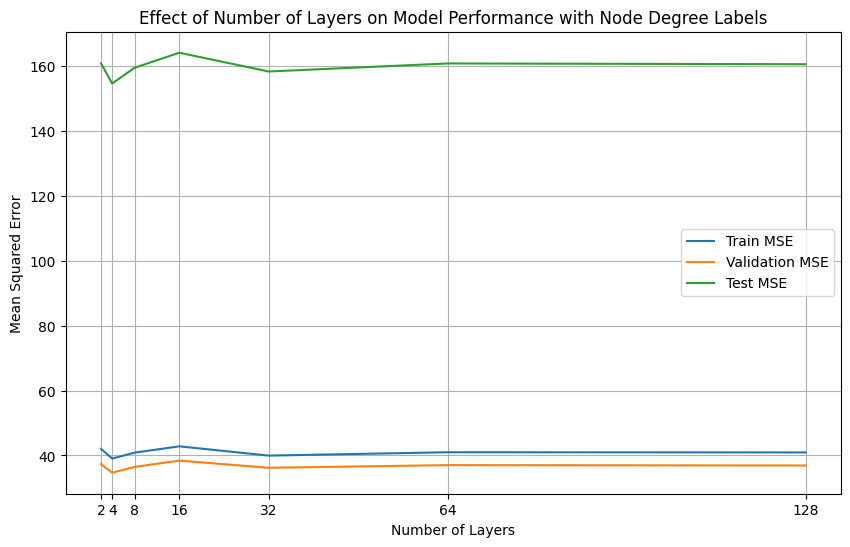

In [14]:
# plot the results
plt.figure(figsize=(10,6))
plt.plot(layer_options, train_losses, label='Train MSE')
plt.plot(layer_options, val_losses, label='Validation MSE')
plt.plot(layer_options, test_losses, label='Test MSE')
plt.xlabel('Number of Layers')
plt.ylabel('Mean Squared Error')
plt.title('Effect of Number of Layers on Model Performance with Node Degree Labels')
plt.xticks(layer_options)
plt.legend()
plt.grid()
plt.show()  

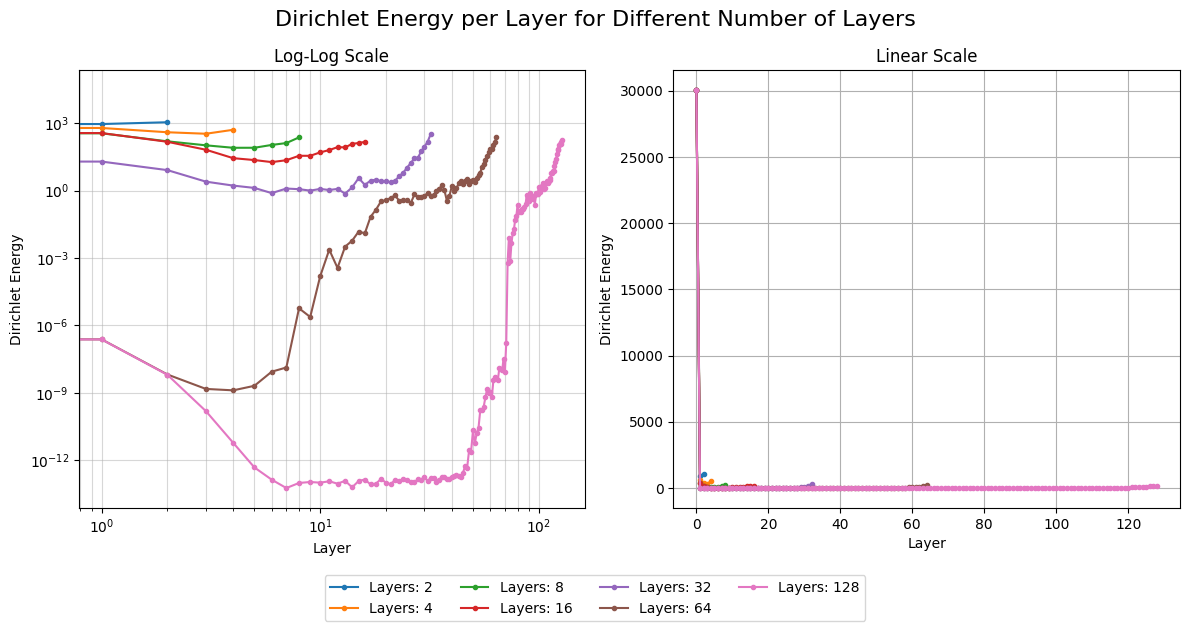

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 

fig.suptitle('Dirichlet Energy per Layer for Different Number of Layers', fontsize=16)

for model in models:
    energies = []
    for layer in range(len(model.convs) + 1):
        out = model.forward_unit_layer(node_split_data.x, node_split_data.edge_index, layer)
        energy = dirichlet_energy(node_split_data.edge_index, out)
        energies.append(energy.item())
    
    ax[0].loglog(range(0, len(model.convs) + 1), energies, marker='.', label=f'Layers: {len(model.convs)}')
    ax[1].plot(range(0, len(model.convs) + 1), energies, marker='.', label=f'Layers: {len(model.convs)}')

ax[0].set_title('Log-Log Scale')
ax[0].set_xlabel('Layer')
ax[0].set_ylabel('Dirichlet Energy')
ax[0].grid(True, which="both", ls="-", alpha=0.5)

ax[1].set_title('Linear Scale')
ax[1].set_xlabel('Layer')
ax[1].set_ylabel('Dirichlet Energy')
ax[1].grid(True)

# Create a single legend below both plots
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4, frameon=True)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15, top=0.88) 
plt.savefig('dirichlet_energy_layers_node_degree_prediction.pdf', bbox_inches='tight')

plt.show()

The figure above shows the results for the Dirichlet energy per layer, for all the different layers of every tested model. We find that in comparison to the previous task, particularly the 32 layer model does not show an as strong decay in Dirichlet energy.

These results indicate that oversmoothing is not solely a mechanical artifact of GNNs, but also influenced by the learning objective. In the original task, the high homophily of the graph meant that nodes with similar features also had similar labels. As a result, the GNN was incentivized to smooth node representations to capture this similarity, leading to oversmoothing. In contrast, predicting node degree does not benefit as much from smoothing, as nodes with similar degrees are not necessarily closely connected.

Nevertheless, we still observe a decay in Dirichlet energy for deeper models, indicating that oversmoothing is still present. This suggests that while the learning objective influences the degree of oversmoothing, the architectural properties of GNNs inherently lead to some level of smoothing as layers are added.

# (e) Analyze how oversmoothing is affected by the choice of the activation function. 

Run experiments with a
linear activation function, and the non-linear activations ReLU and sigmoid and compare the results.

In [16]:
class GNNAct(GNN):
    def __init__(self, input_dim=1433,output_dim=7, hidden_channels=16, num_layers=2, dropout=0.5,inner_layers=GCNConv,output_layer=Linear,activation='linear'):
        super().__init__(input_dim,output_dim, hidden_channels, num_layers, dropout,inner_layers,output_layer)
        self.activation = activation

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            if self.activation == 'relu':
                x = torch.relu(x)
            elif self.activation == 'sigmoid':
                x = torch.sigmoid(x)
            # else linear: do nothing
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        x = self.output_layer(x)

        return F.log_softmax(x, dim=1)
    

Loss: 0.2275, Train Acc: 0.9487, Val Acc: 0.8660, Test Acc: 0.8800: 100%|██████████| 200/200 [00:02<00:00, 99.62it/s] 
Loss: 0.2833, Train Acc: 0.9363, Val Acc: 0.8660, Test Acc: 0.8770: 100%|██████████| 200/200 [00:02<00:00, 71.51it/s]
Loss: 0.4655, Train Acc: 0.9015, Val Acc: 0.8480, Test Acc: 0.8570: 100%|██████████| 200/200 [00:04<00:00, 41.67it/s]
Loss: 1.0515, Train Acc: 0.6449, Val Acc: 0.6200, Test Acc: 0.6330: 100%|██████████| 200/200 [00:08<00:00, 23.25it/s]
Loss: 1.8627, Train Acc: 0.2980, Val Acc: 0.2960, Test Acc: 0.3100: 100%|██████████| 200/200 [00:16<00:00, 12.26it/s]
Loss: 3.5897, Train Acc: 0.2980, Val Acc: 0.2960, Test Acc: 0.3100: 100%|██████████| 200/200 [00:31<00:00,  6.29it/s] 
Loss: 126453.2344, Train Acc: 0.2980, Val Acc: 0.2960, Test Acc: 0.3100: 100%|██████████| 200/200 [01:04<00:00,  3.11it/s] 
Loss: 0.3355, Train Acc: 0.9478, Val Acc: 0.8800, Test Acc: 0.8910: 100%|██████████| 200/200 [00:02<00:00, 89.65it/s]
Loss: 0.5909, Train Acc: 0.8709, Val Acc: 0.8040

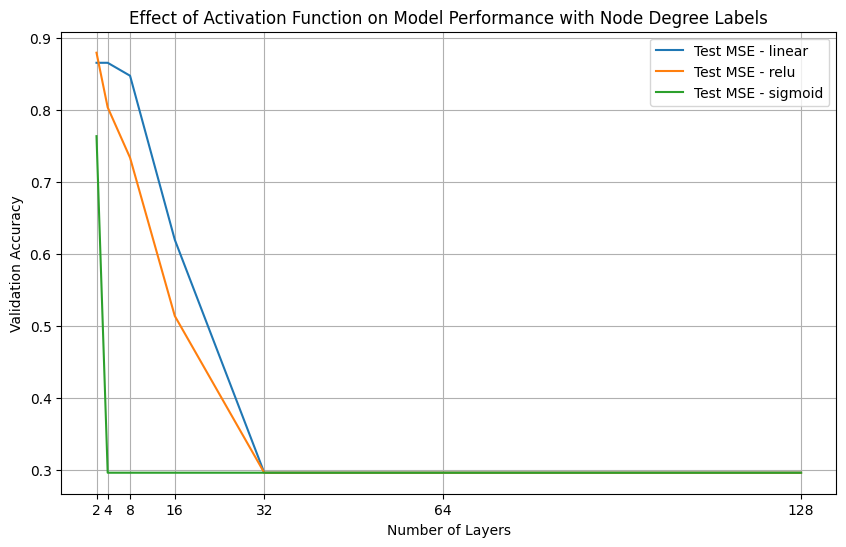

In [17]:
# experiments with different activation functions
activation_functions = ['linear', 'relu', 'sigmoid']
results = {}
for activation in activation_functions:
    models = []
    train_losses = []
    val_losses = []
    test_losses = []

    for layers in layer_options:
        model = GNNAct(hidden_channels=hdim, num_layers=layers, dropout=dropout, inner_layers=conv_layer, activation=activation)
        trainer = Trainer(model, node_split_data, lr=lr)
        trainer.train(epochs=epochs)
        models.append(model)
        train_losses.append(trainer.evaluate(node_split_data.train_mask))
        val_losses.append(trainer.evaluate(node_split_data.val_mask))
        test_losses.append(trainer.evaluate(node_split_data.test_mask))

    results[activation] = {
        'models': models,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_losses': test_losses
    }

# plot the results for different activation functions
plt.figure(figsize=(10,6))
for activation in activation_functions:
    plt.plot(layer_options, results[activation]['val_losses'], label=f'Test MSE - {activation}')
plt.xlabel('Number of Layers')
plt.ylabel('Validation Accuracy')
plt.title('Effect of Activation Function on Model Performance with Node Degree Labels')
plt.xticks(layer_options)
plt.legend()
plt.grid()
plt.savefig('activation_function_comparison_accuracy.pdf', bbox_inches='tight')
plt.show()


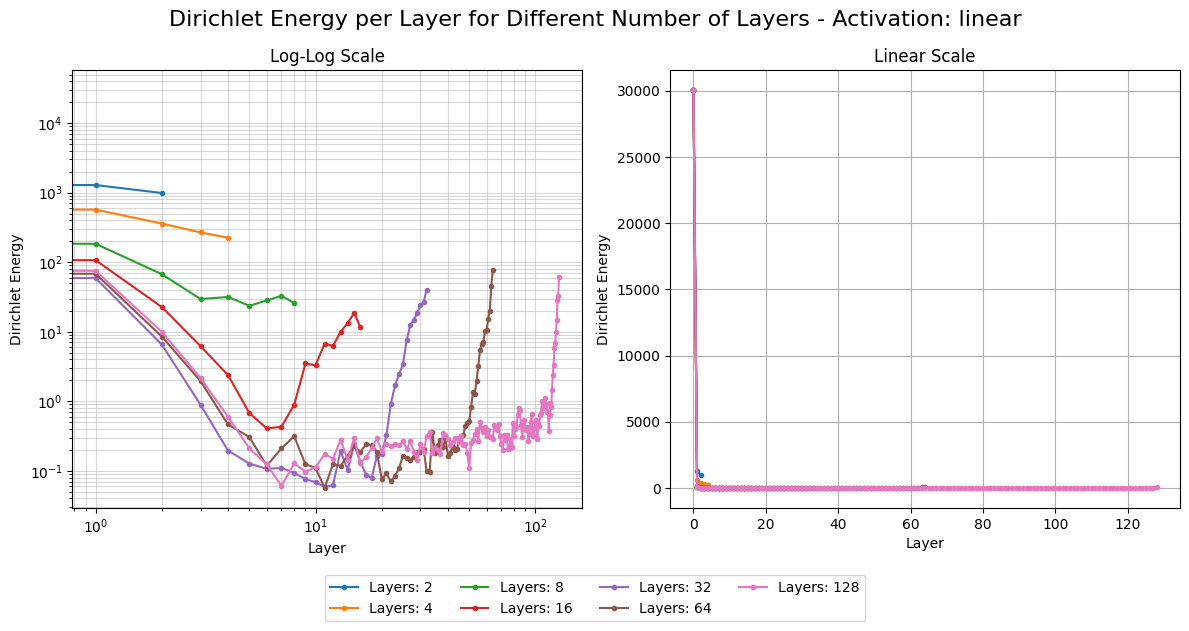

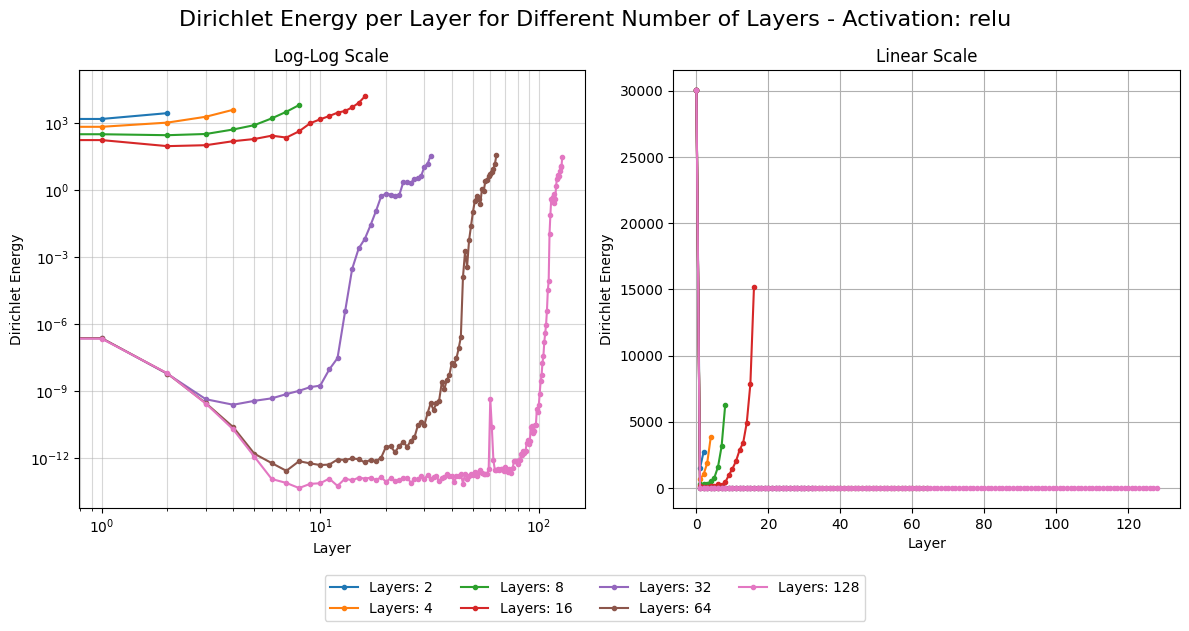

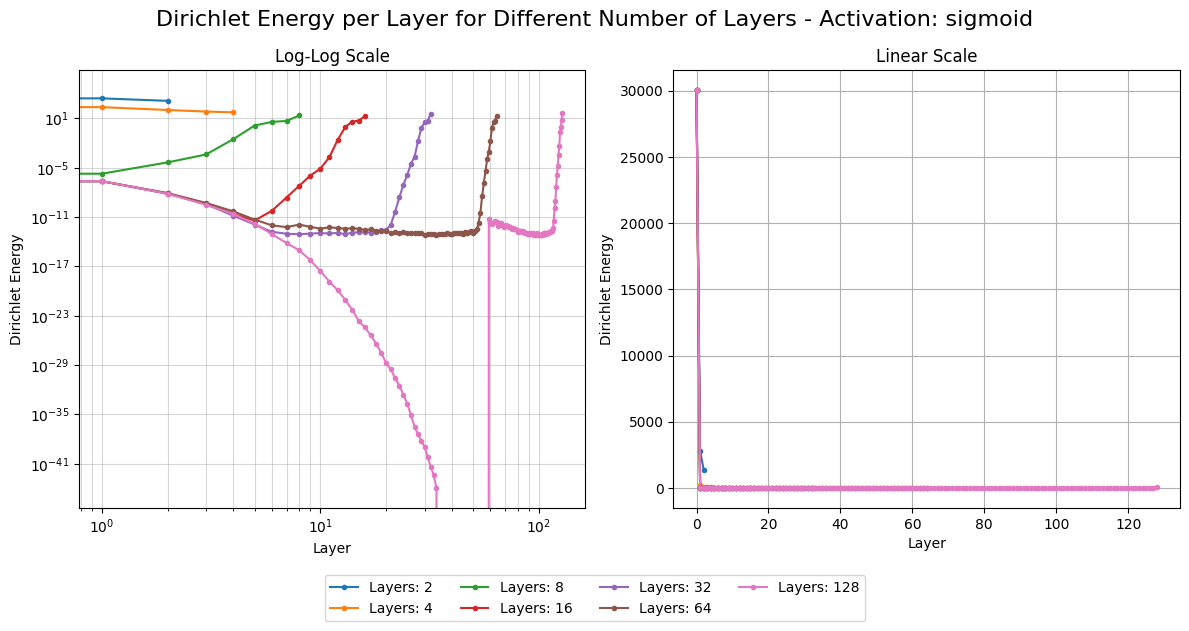

In [18]:
# plot dirichlet energies for different activations
for activation in activation_functions:
    fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 

    fig.suptitle(f'Dirichlet Energy per Layer for Different Number of Layers - Activation: {activation}', fontsize=16)

    for model in results[activation]['models']:
        energies = []
        for layer in range(len(model.convs) + 1):
            out = model.forward_unit_layer(node_split_data.x, node_split_data.edge_index, layer)
            energy = dirichlet_energy(node_split_data.edge_index, out)
            energies.append(energy.item())
        
        ax[0].loglog(range(0, len(model.convs) + 1), energies, marker='.', label=f'Layers: {len(model.convs)}')
        ax[1].plot(range(0, len(model.convs) + 1), energies, marker='.', label=f'Layers: {len(model.convs)}')

    ax[0].set_title('Log-Log Scale')
    ax[0].set_xlabel('Layer')
    ax[0].set_ylabel('Dirichlet Energy')
    ax[0].grid(True, which="both", ls="-", alpha=0.5)

    ax[1].set_title('Linear Scale')
    ax[1].set_xlabel('Layer')
    ax[1].set_ylabel('Dirichlet Energy')
    ax[1].grid(True)

    # Create a single legend below both plots
    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4, frameon=True)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15, top=0.88) 
    plt.savefig(f'dirichlet_energy_layers_activation_{activation}.pdf', bbox_inches='tight')
    plt.show()


The goal of this task was to investigate the influence of different activation functions on the oversmoothing phenomenon. The following activation functions were tested: Linear, ReLU and Sigmoid.

**Performance Accuracy**

The first figure shows the achieved accuracy on the task against the number of layers a model contains for the different activation functions. We observe that the Sigmoid activation function leads to the worst performance overall, as well as the quickest drop in accuracy. Here the accuracy is already only 0.3 for the 4 layer model.

Accuracy is similar for the 2-layer models using ReLU and Linear activation functions. However, with increasing number of layers the linear activation minimally outperforms the ReLU activation, before they both drop to an accuracy of 0.3 at 32 layers.

The poor performance of the sigmoid activation function can be explained by the vanishing gradient problem. The sigmoid function squashes any input value into the range between 0 and 1. Large absolute values are therefore mapped close to these borders. There, the gradient of the sigmoid function is small, leading to very small weight updates during backpropagation. Additionally, this effect gets worse in deep networks, where the gradients are multiplied for each layer during backpropagation.

The slightly better performance of the linear activation function compared to the ReLU activation is likely due to the nature of the Cora dataset. The high homophily in the dataset means that simply taking the average of the neighbors can be a successful strategy to achieve correct classifications.

**Dirichlet Energy**

We find that the Dirichlet energy is immediately the lowest after the first layer for the Sigmoid activation function. This is due to the squashing effect of the sigmoid function, which reduces the variance in the node features. The Dirichlet energy then decreases further after every layer, before increasing again in the last layers due to the use of Cross-Entropy Loss. For the 128 layer model, we observe the Dirichlet energy becoming so small, that the computer can no longer distinguish it from zero. This indicates that the node features have become nearly identical, showing an oversmoothing effect in addition to the squashing effect.

For the Linear activation function, we observe the highest Dirichlet energy after the first layer in all models. This is because the linear activation function does not modify the node features at all, preserving their variance. However, we still observe a strong decay in Dirichlet energy for deeper models, indicating that oversmoothing is still present. Yet, because the linear activation function does neither squash (sigmoid) nor threshold (ReLU) the node features the energy stays higher for longer.

For the ReLU activation function, we again observe a decay in Dirichlet energy for deeper models, indicating the presence of oversmoothing. The ReLU activation function thresholds negative values to zero, which reduces the variance in the node features compared to the linear activation function. However, it does not squash large positive values like the sigmoid function, allowing it to maintain a higher Dirichlet energy than the sigmoid activation.